In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%%sql
INSTALL sqlite;
LOAD sqlite;

,Success


In [5]:
%%sql
ATTACH '400515.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

,Success


In [6]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [7]:
%sql SHOW;

,database,schema,name,column_names,column_types,temporary
0,expdb,main,Join_Message,"[join_message_id, app_received_at]","[BIGINT, TIMESTAMP]",False
1,expdb,main,Message,"[message_id, related_node, network_received_at]","[BIGINT, VARCHAR, TIMESTAMP]",False
2,expdb,main,Node,"[node_deveui, node_appeui, node_appkey, board_...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
3,expdb,main,Power_Consumption,"[power_consumption_id, node_id, timestamp, cur...","[BIGINT, VARCHAR, TIMESTAMP, DOUBLE, DOUBLE, D...",False
4,expdb,main,Radio,"[radio_id, timestamp, node_id, channel, rssi]","[BIGINT, TIMESTAMP, VARCHAR, BIGINT, BIGINT]",False
5,expdb,main,Site,[name],[VARCHAR],False
6,expdb,main,Trace,"[trace_id, node_id, timestamp, message]","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR]",False
7,expdb,main,Uplink_Message,"[uplink_message_id, through_gateway, gateway_r...","[BIGINT, VARCHAR, TIMESTAMP, TIMESTAMP, BIGINT...",False
8,expdb,main,sqlite_sequence,"[name, seq]","[BLOB, BLOB]",False


In [8]:
hej = %sql select message from expdb.Trace WHERE message LIKE 'TIMINGS>%'

In [9]:
%sql nodes =<< select distinct * from expdb.Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,samr34,sx1276,grenoble,stm32Profile,samr34-xpro,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,samr34,sx1276,grenoble,stm32Profile,samr34-xpro,0


In [10]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from expdb.Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA60,1641905,2024-06-11 14:16:01.896818,2024-06-11 14:46:07.668384
1,70B3D57ED005EA59,1613106,2024-06-11 14:16:01.896933,2024-06-11 14:46:07.678142


In [11]:
nodes_with_queries = %sql SELECT node_id, count(*) FROM expdb.Trace WHERE Trace.message like 'Execute Queries%' GROUP BY Trace.node_id;
nodes_with_queries


,node_id,count_star()
0,70B3D57ED005EA60,28
1,70B3D57ED005EA59,28


In [12]:
power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption
#filter to only contain results where we have a query
#power_consumption = power_consumption[power_consumption["node_id"].isin(nodes_with_queries["node_id"])]
power_consumption = power_consumption.set_index("timestamp")
#power_consumption = power_consumption.sort_index()

groups = power_consumption.groupby("node_id")
groups.groups.keys()

dict_keys(['70B3D57ED005EA59', '70B3D57ED005EA60'])

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


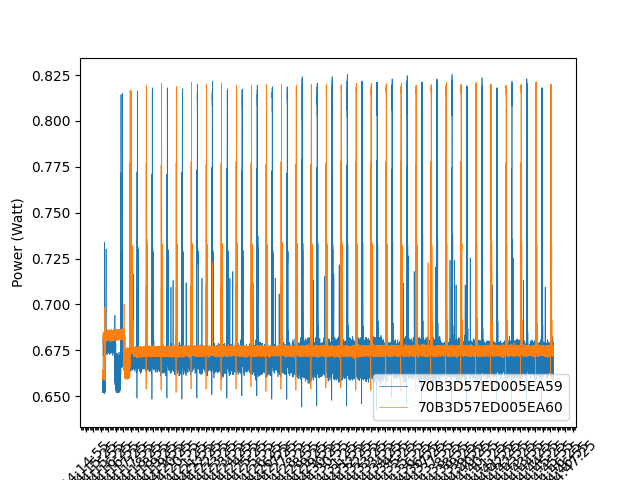

In [13]:
plt.figure()

for node_id, group in groups:
    idxs = np.linspace(0,len(group), len(group), endpoint=False, dtype=int)

    subset = group["power"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

## finding sync signals

In [14]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


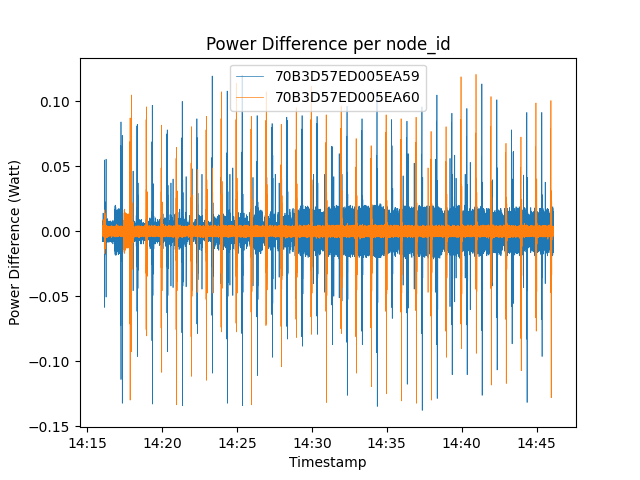

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)
/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [15]:
#diff of each group
power_consumption['power_diff'] = groups["power"].diff()


plt.figure()
for node_id, group in power_consumption.groupby("node_id"):
    idxs = np.linspace(0,len(group), len(group), endpoint=False, dtype=int) # there are comparatively few but big jumps, so hard to see when just taking "random" indexes
    subset = group["power_diff"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

In [17]:
rising_edge = power_consumption[power_consumption["power_diff"] > 0.01].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -0.01].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-06-11 14:16:04.213925,0.675181,0.141190,4.78250,70B3D57ED005EA59,0.014040,rising
2024-06-11 14:16:09.690829,0.733787,0.141971,4.78500,70B3D57ED005EA59,0.054943,rising
2024-06-11 14:16:09.691958,0.675181,0.141092,4.78375,70B3D57ED005EA59,-0.058606,falling
2024-06-11 14:16:09.772706,0.687391,0.141849,4.84500,70B3D57ED005EA60,-0.010988,falling
2024-06-11 14:16:09.784820,0.673960,0.138943,4.84750,70B3D57ED005EA60,-0.010379,falling


In [18]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation
edges['timestamp'] = edges.index.copy()
edges['next_direction'] = edges.groupby('node_id')['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id')['timestamp'].shift(-1)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-06-11 14:16:04.213925,0.675181,0.141190,4.78250,70B3D57ED005EA59,0.014040,rising,2024-06-11 14:16:04.213925,rising,2024-06-11 14:16:09.690829
2024-06-11 14:16:09.690829,0.733787,0.141971,4.78500,70B3D57ED005EA59,0.054943,rising,2024-06-11 14:16:09.690829,falling,2024-06-11 14:16:09.691958
2024-06-11 14:16:09.691958,0.675181,0.141092,4.78375,70B3D57ED005EA59,-0.058606,falling,2024-06-11 14:16:09.691958,rising,2024-06-11 14:16:09.787101
2024-06-11 14:16:09.772706,0.687391,0.141849,4.84500,70B3D57ED005EA60,-0.010988,falling,2024-06-11 14:16:09.772706,falling,2024-06-11 14:16:09.784820
2024-06-11 14:16:09.784820,0.673960,0.138943,4.84750,70B3D57ED005EA60,-0.010379,falling,2024-06-11 14:16:09.784820,falling,2024-06-11 14:16:09.829889


In [34]:
# now to filter out edges that are too close to each other or too far apart. We add 5% tolerance

# filter out edges that are too close to each other or too far apart. We add 5% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp,sync_start,sync_end,next_sync_start,next_sync_end
timestamp,,,,,,,,,,,,,
2024-06-11 14:17:14.912365,0.700821,0.146611,4.78250,70B3D57ED005EA59,0.010988,rising,2024-06-11 14:17:14.912365,falling,2024-06-11 14:17:15.111622,2024-06-11 14:17:14.812365,2024-06-11 14:17:15.211622,2024-06-11 14:17:15.214235,2024-06-11 14:17:15.614590
2024-06-11 14:17:15.314235,0.694717,0.145195,4.78250,70B3D57ED005EA59,0.023809,rising,2024-06-11 14:17:15.314235,falling,2024-06-11 14:17:15.514590,2024-06-11 14:17:15.214235,2024-06-11 14:17:15.614590,2024-06-11 14:18:19.816702,2024-06-11 14:18:20.217057
2024-06-11 14:17:51.472985,0.702042,0.144975,4.84375,70B3D57ED005EA60,0.025029,rising,2024-06-11 14:17:51.472985,falling,2024-06-11 14:17:51.673157,2024-06-11 14:17:51.372985,2024-06-11 14:17:51.773157,2024-06-11 14:17:51.776594,2024-06-11 14:17:52.175637
2024-06-11 14:17:51.876594,0.705705,0.145683,4.84375,70B3D57ED005EA60,0.012209,rising,2024-06-11 14:17:51.876594,falling,2024-06-11 14:17:52.075637,2024-06-11 14:17:51.776594,2024-06-11 14:17:52.175637,2024-06-11 14:18:56.377627,2024-06-11 14:18:56.777768
2024-06-11 14:18:19.916702,0.700211,0.146391,4.78250,70B3D57ED005EA59,0.026861,rising,2024-06-11 14:18:19.916702,falling,2024-06-11 14:18:20.117057,2024-06-11 14:18:19.816702,2024-06-11 14:18:20.217057,2024-06-11 14:18:20.219671,2024-06-11 14:18:20.618927


In [35]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp,sync_start,sync_end,next_sync_start,next_sync_end
timestamp,,,,,,,,,,,,,
2024-06-11 14:17:14.912365,0.700821,0.146611,4.78250,70B3D57ED005EA59,0.010988,rising,2024-06-11 14:17:14.912365,falling,2024-06-11 14:17:15.111622,2024-06-11 14:17:14.812365,2024-06-11 14:17:15.211622,2024-06-11 14:17:15.214235,2024-06-11 14:17:15.614590
2024-06-11 14:17:15.314235,0.694717,0.145195,4.78250,70B3D57ED005EA59,0.023809,rising,2024-06-11 14:17:15.314235,falling,2024-06-11 14:17:15.514590,2024-06-11 14:17:15.214235,2024-06-11 14:17:15.614590,2024-06-11 14:18:19.816702,2024-06-11 14:18:20.217057
2024-06-11 14:17:51.472985,0.702042,0.144975,4.84375,70B3D57ED005EA60,0.025029,rising,2024-06-11 14:17:51.472985,falling,2024-06-11 14:17:51.673157,2024-06-11 14:17:51.372985,2024-06-11 14:17:51.773157,2024-06-11 14:17:51.776594,2024-06-11 14:17:52.175637
2024-06-11 14:17:51.876594,0.705705,0.145683,4.84375,70B3D57ED005EA60,0.012209,rising,2024-06-11 14:17:51.876594,falling,2024-06-11 14:17:52.075637,2024-06-11 14:17:51.776594,2024-06-11 14:17:52.175637,2024-06-11 14:18:56.377627,2024-06-11 14:18:56.777768
2024-06-11 14:18:19.916702,0.700211,0.146391,4.78250,70B3D57ED005EA59,0.026861,rising,2024-06-11 14:18:19.916702,falling,2024-06-11 14:18:20.117057,2024-06-11 14:18:19.816702,2024-06-11 14:18:20.217057,2024-06-11 14:18:20.219671,2024-06-11 14:18:20.618927


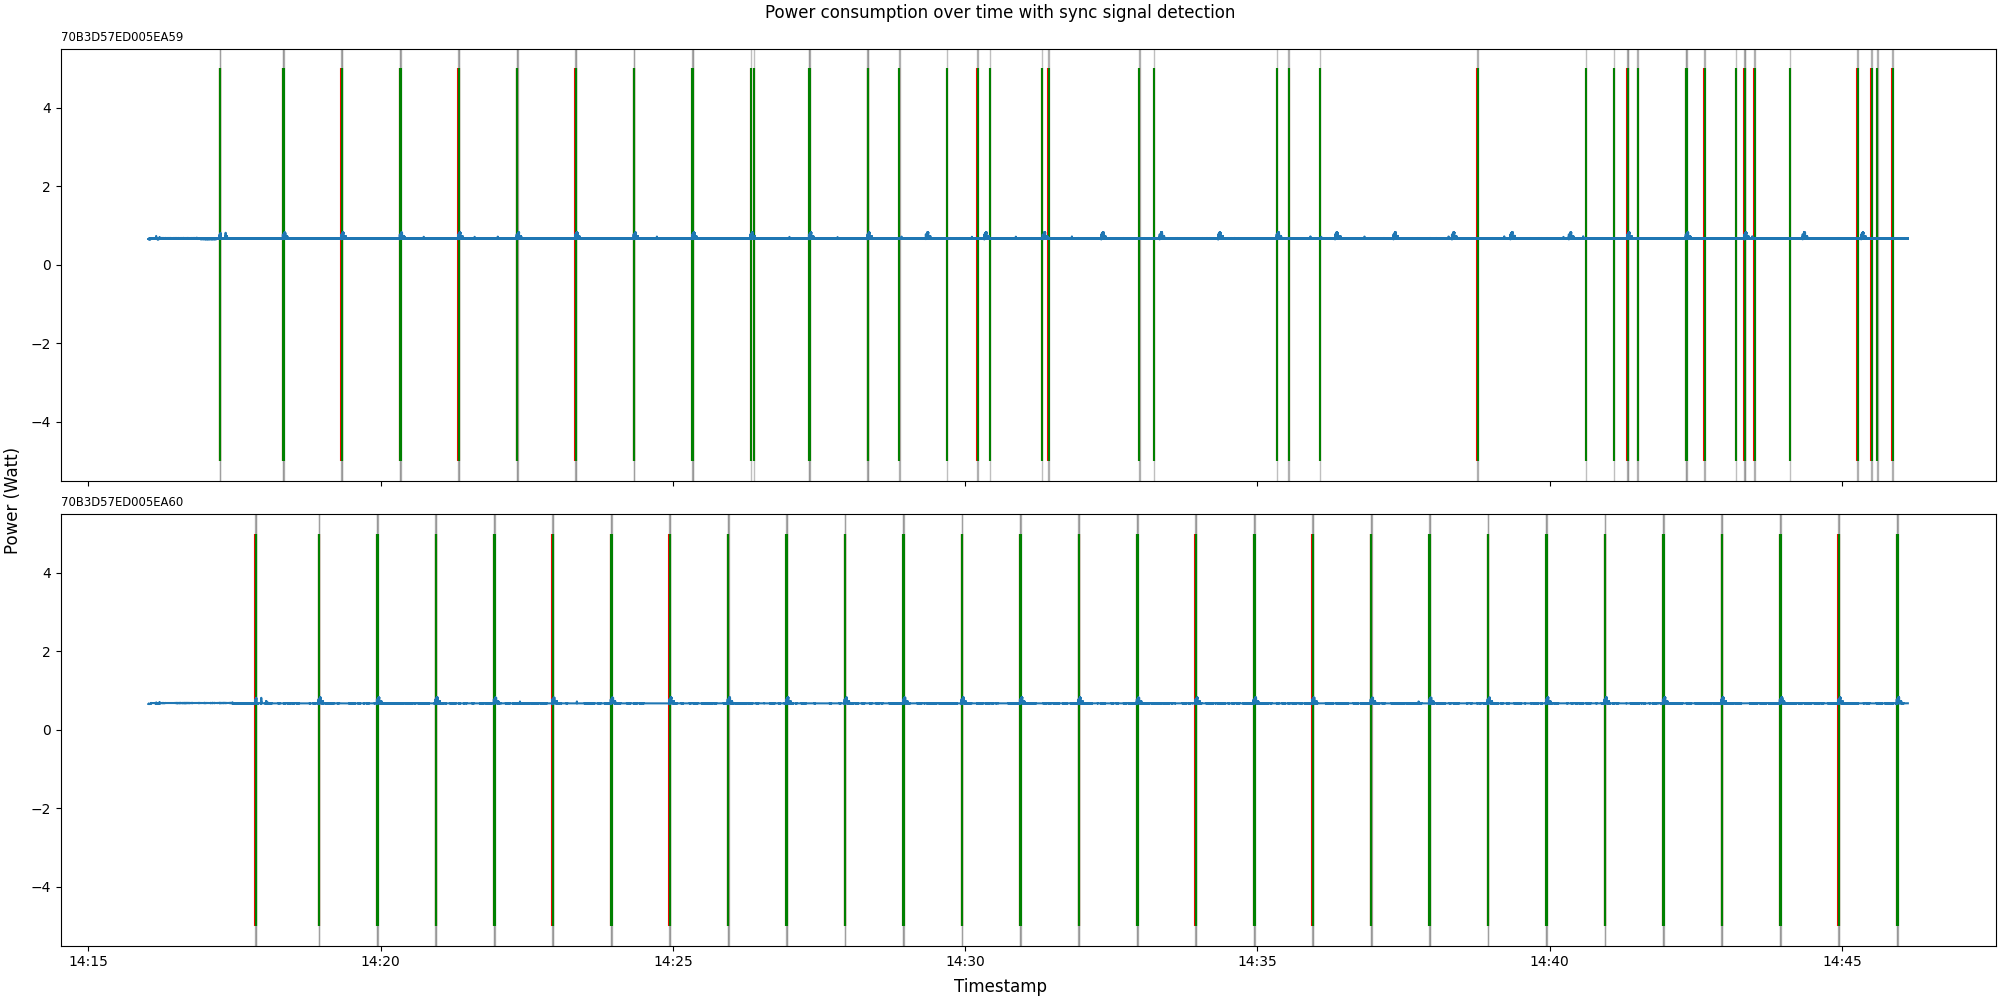

In [36]:
groups_by_node_id = power_consumption.groupby('node_id')
edges_by_node_id = edges.groupby('node_id')

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained', figsize=(20, 10))
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with sync signal detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)
        ax.vlines(edges_grouped['timestamp'], ymin=-5, ymax=5, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=-5, ymax=5, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    idxs = np.linspace(0, len(group), endpoint=False, num=1000000, dtype=int)
    subset = group["power"].iloc[idxs]
    ax.plot(subset.index, subset, label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')
plt.show()

In [37]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id')
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500)][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = loops.groupby('node_id').cumcount()
loops[['node_id','loop_num']]


,node_id,loop_num
timestamp,,
2024-06-11 14:17:14.912365,70B3D57ED005EA59,0
2024-06-11 14:17:51.472985,70B3D57ED005EA60,0
2024-06-11 14:18:19.916702,70B3D57ED005EA59,1
2024-06-11 14:18:56.477627,70B3D57ED005EA60,1
2024-06-11 14:19:19.916126,70B3D57ED005EA59,2
2024-06-11 14:19:56.476105,70B3D57ED005EA60,2
2024-06-11 14:20:19.915062,70B3D57ED005EA59,3
2024-06-11 14:20:56.474491,70B3D57ED005EA60,3
2024-06-11 14:21:19.914486,70B3D57ED005EA59,4


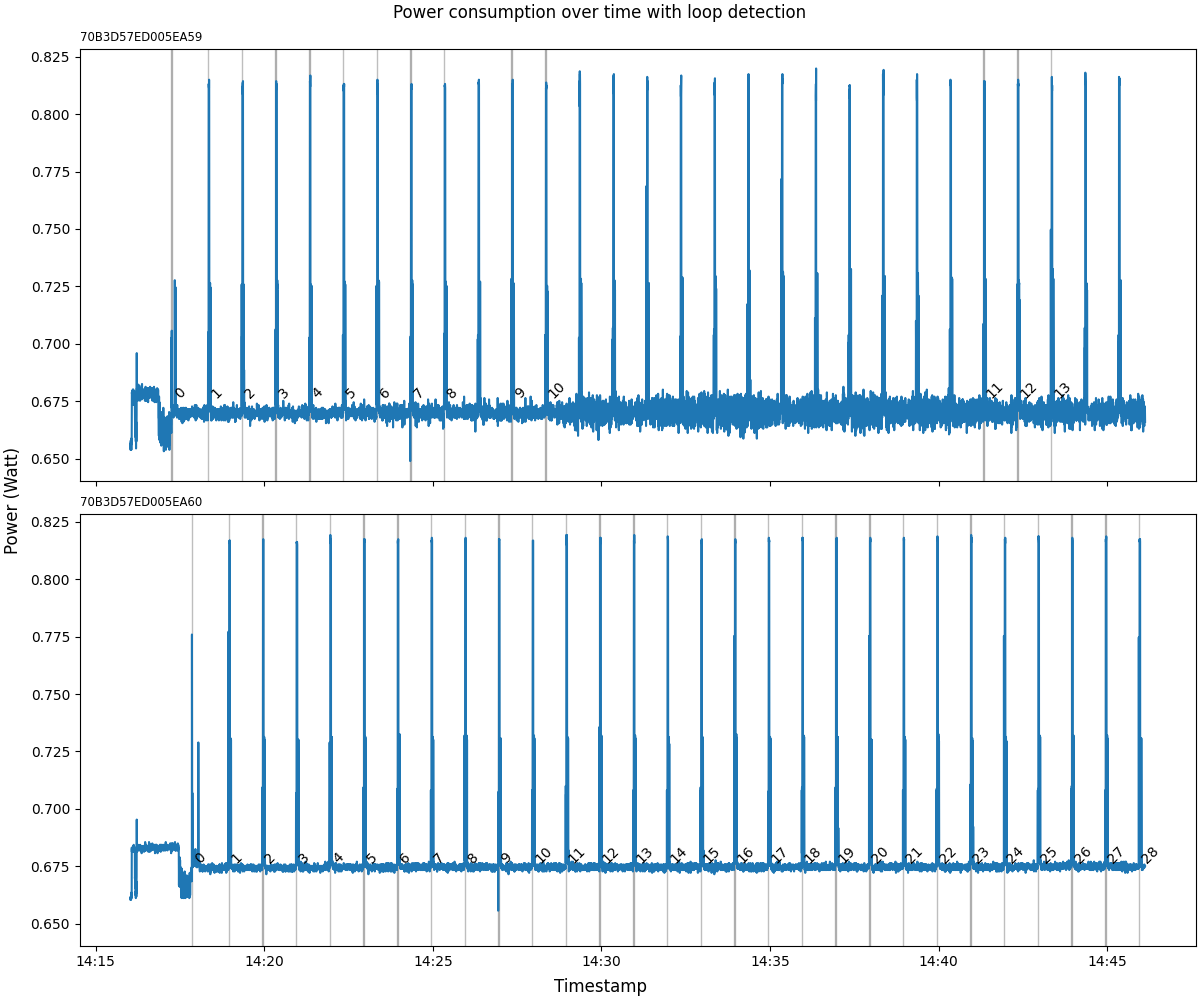

In [38]:

groups_by_node_id = power_consumption.groupby('node_id')
loops_by_node_id = loops.groupby('node_id')
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, figsize=(12, 10), layout='constrained')
text_y_pos = power_consumption['power'].mean()
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with loop detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, text_y_pos, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    idxs = np.linspace(0, len(group), endpoint=False, num=10000, dtype=int)
    subset = group["power"].iloc[idxs]

    ax.plot(subset.index, subset,label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [24]:
%%sql timings << SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*deserialize: (-?[0-9]+)',1) as deserialize_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'

In [25]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
timings['node_id'].unique()

array(['70B3D57ED005EA59', '70B3D57ED005EA60'], dtype=object)

In [26]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-06-11 14:17:14.812365,2024-06-11 14:17:14.912365,70B3D57ED005EA59,2024-06-11 14:17:15.614590,0,2024-06-11 14:17:24.266600,805,21,3,19,5234,56,26,3266,4,55
2024-06-11 14:17:51.372985,2024-06-11 14:17:51.472985,70B3D57ED005EA60,2024-06-11 14:17:52.175637,0,2024-06-11 14:18:04.827932,805,21,3,19,5234,56,26,7264,4,51
2024-06-11 14:18:19.816702,2024-06-11 14:18:19.916702,70B3D57ED005EA59,2024-06-11 14:18:20.618927,1,2024-06-11 14:18:25.064207,805,21,79,18,57,200,35,4009,4,54
2024-06-11 14:18:56.377627,2024-06-11 14:18:56.477627,70B3D57ED005EA60,2024-06-11 14:18:57.180310,1,2024-06-11 14:19:01.624441,805,21,79,19,56,200,35,4010,4,54
2024-06-11 14:19:19.816126,2024-06-11 14:19:19.916126,70B3D57ED005EA59,2024-06-11 14:19:20.618351,2,2024-06-11 14:19:25.062414,805,21,79,19,56,200,35,4010,4,54


In [27]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["deserialize_start"] = loops["load_end"]
loops["deserialize_end"] = loops["deserialize_start"] + pd.to_timedelta(loops["deserialize_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["deserialize_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["sensor_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available



,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
loop_signal_start,,,,,,,,,,,,,,,,,,,,,
2024-06-11 14:17:14.812365,2024-06-11 14:17:14.912365,70B3D57ED005EA59,2024-06-11 14:17:15.614590,0,2024-06-11 14:17:24.266600,805,21,3,19,5234,...,2024-06-11 14:17:20.894365,2024-06-11 14:17:20.950365,2024-06-11 14:17:20.950365,2024-06-11 14:17:20.976365,2024-06-11 14:17:20.976365,2024-06-11 14:17:24.242365,2024-06-11 14:17:24.242365,2024-06-11 14:17:24.246365,2024-06-11 14:17:24.246365,2024-06-11 14:18:19.246365
2024-06-11 14:17:51.372985,2024-06-11 14:17:51.472985,70B3D57ED005EA60,2024-06-11 14:17:52.175637,0,2024-06-11 14:18:04.827932,805,21,3,19,5234,...,2024-06-11 14:17:57.454985,2024-06-11 14:17:57.510985,2024-06-11 14:17:57.510985,2024-06-11 14:17:57.536985,2024-06-11 14:17:57.536985,2024-06-11 14:18:04.800985,2024-06-11 14:18:04.800985,2024-06-11 14:18:04.804985,2024-06-11 14:18:04.804985,2024-06-11 14:18:55.804985
2024-06-11 14:18:19.816702,2024-06-11 14:18:19.916702,70B3D57ED005EA59,2024-06-11 14:18:20.618927,1,2024-06-11 14:18:25.064207,805,21,79,18,57,...,2024-06-11 14:18:20.796702,2024-06-11 14:18:20.996702,2024-06-11 14:18:20.996702,2024-06-11 14:18:21.031702,2024-06-11 14:18:21.031702,2024-06-11 14:18:25.040702,2024-06-11 14:18:25.040702,2024-06-11 14:18:25.044702,2024-06-11 14:18:25.044702,2024-06-11 14:19:19.044702
2024-06-11 14:18:56.377627,2024-06-11 14:18:56.477627,70B3D57ED005EA60,2024-06-11 14:18:57.180310,1,2024-06-11 14:19:01.624441,805,21,79,19,56,...,2024-06-11 14:18:57.357627,2024-06-11 14:18:57.557627,2024-06-11 14:18:57.557627,2024-06-11 14:18:57.592627,2024-06-11 14:18:57.592627,2024-06-11 14:19:01.602627,2024-06-11 14:19:01.602627,2024-06-11 14:19:01.606627,2024-06-11 14:19:01.606627,2024-06-11 14:19:55.606627
2024-06-11 14:19:19.816126,2024-06-11 14:19:19.916126,70B3D57ED005EA59,2024-06-11 14:19:20.618351,2,2024-06-11 14:19:25.062414,805,21,79,19,56,...,2024-06-11 14:19:20.796126,2024-06-11 14:19:20.996126,2024-06-11 14:19:20.996126,2024-06-11 14:19:21.031126,2024-06-11 14:19:21.031126,2024-06-11 14:19:25.041126,2024-06-11 14:19:25.041126,2024-06-11 14:19:25.045126,2024-06-11 14:19:25.045126,2024-06-11 14:20:19.045126
2024-06-11 14:19:56.376105,2024-06-11 14:19:56.476105,70B3D57ED005EA60,2024-06-11 14:19:57.178757,2,2024-06-11 14:20:01.623057,805,21,79,19,56,...,2024-06-11 14:19:57.356105,2024-06-11 14:19:57.556105,2024-06-11 14:19:57.556105,2024-06-11 14:19:57.591105,2024-06-11 14:19:57.591105,2024-06-11 14:20:01.601105,2024-06-11 14:20:01.601105,2024-06-11 14:20:01.605105,2024-06-11 14:20:01.605105,2024-06-11 14:20:55.605105
2024-06-11 14:20:19.815062,2024-06-11 14:20:19.915062,70B3D57ED005EA59,2024-06-11 14:20:20.617317,3,2024-06-11 14:20:25.062407,805,21,79,19,56,...,2024-06-11 14:20:20.795062,2024-06-11 14:20:20.995062,2024-06-11 14:20:20.995062,2024-06-11 14:20:21.030062,2024-06-11 14:20:21.030062,2024-06-11 14:20:25.040062,2024-06-11 14:20:25.040062,2024-06-11 14:20:25.044062,2024-06-11 14:20:25.044062,2024-06-11 14:21:19.044062
2024-06-11 14:20:56.374491,2024-06-11 14:20:56.474491,70B3D57ED005EA60,2024-06-11 14:20:57.177174,3,2024-06-11 14:21:01.621717,805,21,79,19,56,...,2024-06-11 14:20:57.354491,2024-06-11 14:20:57.554491,2024-06-11 14:20:57.554491,2024-06-11 14:20:57.589491,2024-06-11 14:20:57.589491,2024-06-11 14:21:01.599491,2024-06-11 14:21:01.599491,2024-06-11 14:21:01.603491,2024-06-11 14:21:01.603491,2024-06-11 14:21:55.603491
2024-06-11 14:21:19.814486,2024-06-11 14:21:19.914486,70B3D57ED005EA59,2024-06-11 14:21:20.616741,4,2024-06-11 14:21:25.061339,805,21,79,19,56,...,2024-06-11 14:21:20.794486,2024-06-11 14:21:20.994486,2024-06-11 14:21:20.994486,2024-06-11 14:21:21.029486,2024-06-11 14:21:21.029486,2024-06-11 14:21:25.039486,2024-06-11 14:21:25.039486,2024-06-11

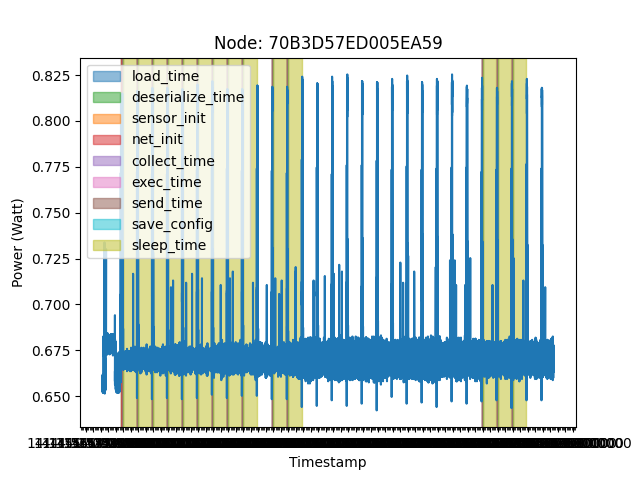

In [29]:
node_id = nodes_with_queries.iloc[1]["node_id"]
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data.index, power_data["power"])
for row in timing_data.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.deserialize_start, row.deserialize_end, color='tab:green', alpha=0.5, label="deserialize_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))
plt.title(f"Node: {node_id}")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [ ]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [ ]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [ ]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [ ]:
%sql SELECT * from expdb.Content_Message

,content_message_id,frame_counter,frame_port,frame_payload
0,2,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
1,3,0,2,PDM=
2,5,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
3,6,0,2,PDM=


In [ ]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,iotlab-ttn-gateway-gra,2024-06-11 14:17:21,2024-06-11 14:17:21.319262,-36,7.25,125000,867500000,0.046336,SF7,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-06-11 14:17:21.107201
1,iotlab-ttn-gateway-gra,2024-06-11 14:17:58,2024-06-11 14:17:57.863616,-40,8.50,125000,867700000,0.046336,SF7,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA60,2024-06-11 14:17:57.657473


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [ ]:
%%sql
select * from expdb.Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,samr34,sx1276,grenoble,stm32Profile,samr34-xpro,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,samr34,sx1276,grenoble,stm32Profile,samr34-xpro,0


In [ ]:
loops.groupby('node_id')['loop_num'].max()

Series([], Name: loop_num, dtype: int64)

## Calculate Total Energy Consumed per region

In [ ]:
np.sum((np.abs(np.diff(power_consumption.index.to_numpy())) / np.timedelta64(1, 's')) * power_consumption["power"].values[:-1])

3648.076265785048

In [ ]:
#define function to calculate energy consumed

def calc_energy_consumed(df: pd.DataFrame):

    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    #     # ensure we only calculate for data frames containing data from a single node
    # assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # # assert df have columns "power" and index of "timestamp" type
    # assert "power" in df.columns, "power column not found"
    # assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.array
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [ ]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "deserialize": calc_energy_consumed(power_consumption_for_node.loc[series_loops["deserialize_start"]:series_loops["deserialize_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,timestamp_x,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,collect_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
count,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
mean,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
min,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
25%,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
50%,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
75%,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
max,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import scipy.stats as st
import statsmodels.stats.api as smstats

def calc_confidence_interval(series: pd.Series) -> pd.Series:
    low, high = smstats.DescrStatsW(series).tconfint_mean(alpha=0.05)
    #low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [ ]:
energy_consumed

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
loop_signal_start,,,,,,,,,,,,,,,,,,,,,


In [ ]:
columns_without_totals = ["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]
columns = ["total", "total without loop signal"] + columns_without_totals

In [ ]:
error_bounds = energy_consumed[columns].apply(calc_confidence_interval)


KeyError: "None of [Index(['total', 'total without loop signal', 'loop signal', 'load config',\n       'deserialize', 'sensor init', 'net init', 'sensor collect',\n       'query execution', 'send', 'save config', 'sleep'],\n      dtype='object')] are in the [columns]"

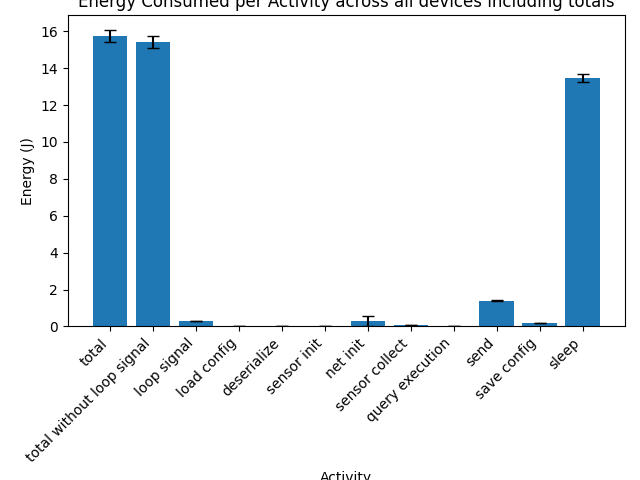

In [ ]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[columns]

## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
error_relative = np.abs(error_bounds - to_plot.loc["mean"])

plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

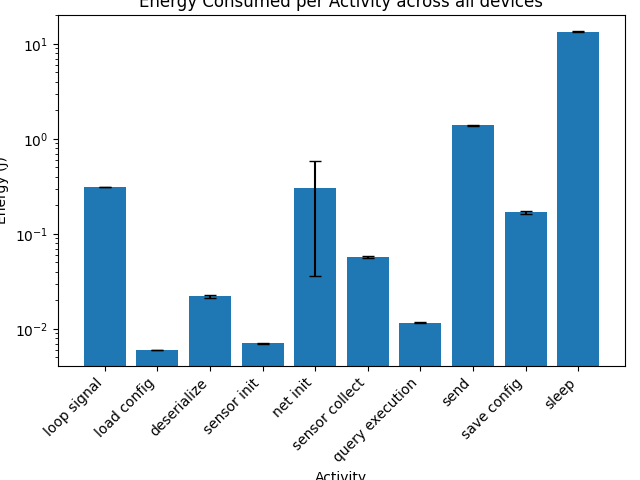

In [ ]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[columns_without_totals]
error_relative = np.abs(error_bounds[columns_without_totals] - to_plot.loc["mean"])
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative, log=True, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [ ]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [ ]:
error_bounds_without_0th_loop = without_0th_loop[columns].apply(calc_confidence_interval)


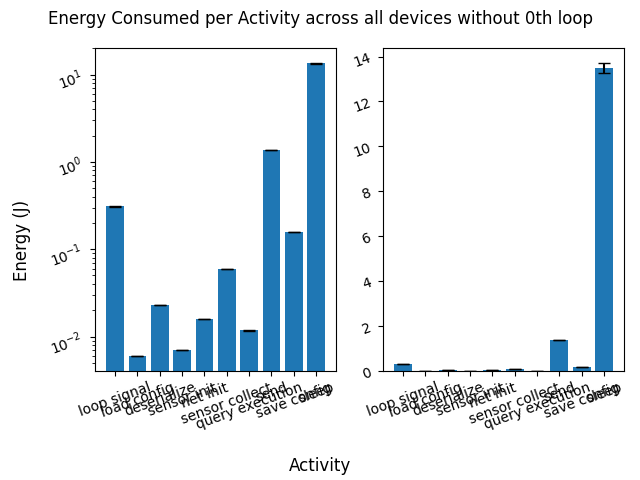

In [ ]:
to_plot = without_0th_loop_summary[columns_without_totals]

errors_relative = np.abs(error_bounds_without_0th_loop[columns_without_totals] - to_plot.loc["mean"])
#energy_consumed_without_0th_loop
## plot both with log scale and without
fig, (ax1, ax2) =  plt.subplots(1,2)

fig.suptitle("Energy Consumed per Activity across all devices without 0th loop")
fig.supxlabel("Activity")
fig.supylabel("Energy (J)")

ax1.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4, log=True)
ax1.tick_params(labelrotation=20)

ax2.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4)
ax2.tick_params(labelrotation=20)



plt.tight_layout()
plt.show()

In [ ]:
without_0th_loop.groupby("node_id").describe()

loop_num                                               total  \
                    count  mean       std  min   25%   50%    75%   max count   
node_id                                                                         
70B3D57ED005EA59     28.0  14.5  8.225975  1.0  7.75  14.5  21.25  28.0  28.0   
70B3D57ED005EA60     27.0  14.0  7.937254  1.0  7.50  14.0  20.50  27.0  27.0   
70B3D57ED005EA61     26.0  13.5  7.648529  1.0  7.25  13.5  19.75  26.0  26.0   
70B3D57ED005EA62     25.0  13.0  7.359801  1.0  7.00  13.0  19.00  25.0  25.0   
70B3D57ED005EA63     24.0  12.5  7.071068  1.0  6.75  12.5  18.25  24.0  24.0   
70B3D57ED005EA65     23.0  12.0  6.782330  1.0  6.50  12.0  17.50  23.0  23.0   
70B3D57ED005EA66     22.0  11.5  6.493587  1.0  6.25  11.5  16.75  22.0  22.0   
70B3D57ED005EA67     20.0  10.5  5.916080  1.0  5.75  10.5  15.25  20.0  20.0   
70B3D57ED005EA69     19.0  10.0  5.627314  1.0  5.50  10.0  14.50  19.0  19.0   

                             ... save config           sleep             \
                       mean  ...         75%       max count       mean   
node_id                      ...                                          
70B3D57ED005EA59  15.737400  ...    0.164141  0.165919  28.0  13.843811   
70B3D57ED005EA60  15.896924  ...    0.162016  0.163669  27.0  13.895695   
70B3D57ED005EA61  15.698810  ...    0.158151  0.159293  26.0  13.727269   
70B3D57ED005EA62  15.669011  ...    0.158158  0.159265  25.0  13.712548   
70B3D57ED005EA63  15.424060  ...    0.159108  0.160609  24.0  13.437723   
70B3D57ED005EA65  15.709832  ...    0.160169  0.161728  23.0  13.702312   
70B3D57ED005EA66  15.441765  ...    0.159694  0.162683  22.0  13.474151   
70B3D57ED005EA67  13.941676  ...    0.143891  0.144755  20.0  12.135474   
70B3D57ED005EA69  14.965878  ...    0.160223  0.160390  19.0  12.977586   

                                                                        \
                       std        min        25%        50%        75%   
node_id                                                                  
70B3D57ED005EA59  2.249858   2.369363  14.283653  14.286776  14.289642   
70B3D57ED005EA60  0.622368  10.782336  14.002176  14.014347  14.024453   
70B3D57ED005EA61  0.004778  13.717599  13.722978  13.727912  13.731369   
70B3D57ED005EA62  0.003801  13.707370  13.710112  13.711687  13.714780   
70B3D57ED005EA63  1.534488   6.233571  13.747846  13.749578  13.750429   
70B3D57ED005EA65  1.697360   5.916087  14.048685  14.054242  14.058649   
70B3D57ED005EA66  1.182692   8.180001  13.710930  13.721423  13.739793   
70B3D57ED005EA67  0.462841  10.169774  12.229897  12.231784  12.249990   
70B3D57ED005EA69  3.001609   0.582507  13.661017  13.666772  13.669172   

                             
                        max  
node_id                      
70B3D57ED005EA59  14.302092  
70B3D57ED005EA60  14.043555  
70B3D57ED005EA61  13.734917  
70B3D57ED005EA62  13.723561  
70B3D57ED005EA63  13.768005  
70B3D57ED005EA65  14.072813  
70B3D57ED005EA66  13.784229  
70B3D57ED005EA67  12.262761  
70B3D57ED005EA69  13.674112  

[9 rows x 104 columns]

In [ ]:
## plot per node
grouped = without_0th_loop[['node_id'] + columns_without_totals] \
    .groupby("node_id")
# grouped_agg = grouped.agg(["mean", "std"])
# def hej(row: pd.Series):
#     outermost_column = list(set(k[0] for k in row.keys()))
#     idx = pd.MultiIndex.from_product([outermost_column, ["low","high"]])
#     res = pd.Series(index=idx)
#     for col in outermost_column:
#         res[col] = calc_confidence_interval(row[col])
#     return res
# ci = grouped_agg.apply(hej, axis=1)

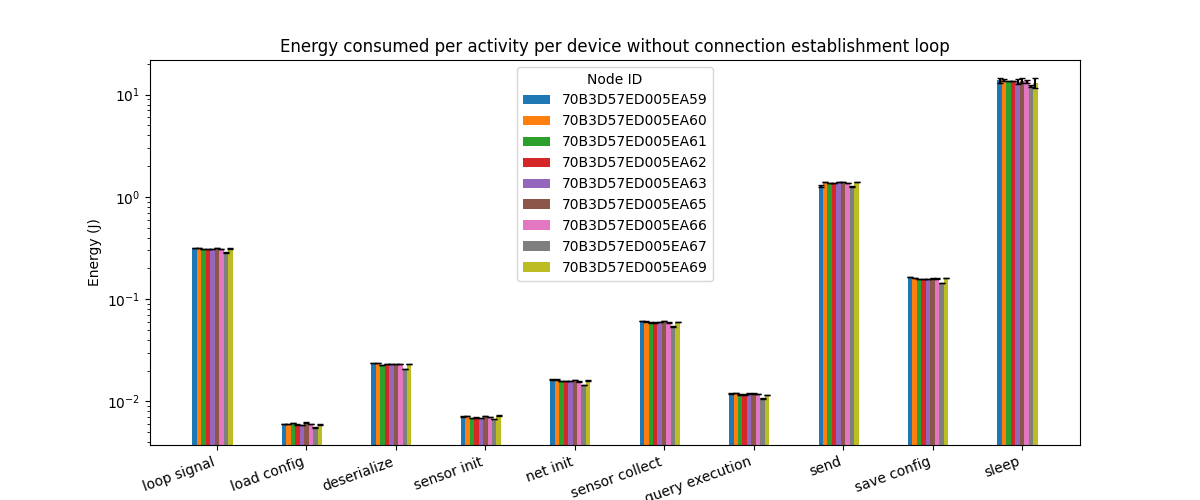

In [ ]:
locations = np.arange(len(columns_without_totals))
width = 0.05
multiplier = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for node_id, row in grouped:
    values = row[columns_without_totals].mean().values
    error_bounds = row[columns_without_totals].apply(calc_confidence_interval)
    errors_relative = np.abs(error_bounds - values)
    #values = row.loc[node_id,(slice(None),"mean")][columns].values
    #errors_low = values - ci.loc[node_id,(slice(None),"low")][columns]
    #errors_high = ci.loc[node_id,(slice(None),"high")][columns] - values
    # for node_id, mean in row.loc[activity,"mean"].items():
    offset = width * multiplier

    rects = ax.bar(locations + offset, values, width, capsize=2, label=node_id, yerr=errors_relative, log=True)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(title="Node ID")
ax.set_title("Energy consumed per activity per device without connection establishment loop")
ax.set_ylabel("Energy (J)")
ax.set_xlabel("Activity")
ax.set_xticks(locations + 0.25, columns_without_totals, rotation=20, ha="right")
plt.show()

In [ ]:
import gc
gc.collect()

2229

In [ ]:

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse

# TODO: from Viktor
# before doing the above try to from the data you have derive a power consumption per time period and estimate the powerconsumption linearly based on the time the activity takes
# regarding outliars in the total plot. Remove them. 
